# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

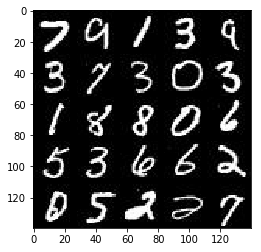

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

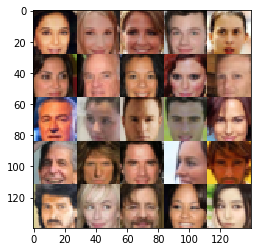

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    fake = tf.placeholder(tf.float32, [None, z_dim])
    learn_rate = tf.placeholder(tf.float32)

    return real, fake, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        #Shape starts as 28*28*3
        x1 = tf.layers.conv2d(inputs=images, 
                              filters=64, 
                              kernel_size=(5, 5), 
                              strides=(2, 2), 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        #Apply leaky relu
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.9)
        #Shape now is: 14*14*64
        
        x2 = tf.layers.conv2d(inputs=x1, 
                              filters=128, 
                              kernel_size=(5, 5), 
                              strides=(2, 2), 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        #Use batch normalization.
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2*alpha)
        x2 = tf.nn.dropout(x2, 0.9)
        #Shape is now: 7*7*128
        
        x3 = tf.layers.conv2d(inputs=x2, 
                              filters=256, 
                              kernel_size=(5, 5), 
                              strides=(2, 2), 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3 * alpha)
        #Shape is now: 4*4*256
        
        #Flatten
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        #Reshape to start deconvolutions.
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.contrib.layers.dropout(x1, 0.5, is_training=is_train)
        
        x2 = tf.layers.conv2d_transpose(inputs=x1, 
                                        filters=256, 
                                        kernel_size=(4, 4), 
                                        strides=(2,2), 
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.contrib.layers.dropout(x2, 0.5, is_training=is_train)
        #Shape is 8*8*256
        
        x3 = tf.layers.conv2d_transpose(inputs=x2,
                                        filters=128,
                                        kernel_size=(4, 4),
                                        strides=(2, 2),
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.contrib.layers.dropout(x3, 0.5, is_training=is_train)
        #Shape is now 16*16*128
        
        x4 = tf.layers.conv2d_transpose(inputs=x3, 
                                        filters=out_channel_dim, 
                                        kernel_size=(5, 5), 
                                        strides=(2, 2), 
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha*x4, x4)
        
        #Shape is now 32*32*3
        #Final layer to add depth.
        logits = tf.layers.conv2d(inputs=x4, 
                                  filters=out_channel_dim, 
                                  kernel_size=(5, 5), 
                                  strides=(1, 1), 
                                  padding='valid',
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.tanh(logits)
        
        #output = tf.image.resize_images(logits, (28, 28))
        #Shape is now 28*28*3

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_output = generator(input_z, out_channel_dim, is_train=True)
    d_logits_real = discriminator(input_real)
    d_logits_fake = discriminator(g_output, reuse=True)
    
    smooth_val = 0.1
    smooth_factor = (1 - smooth_val)
    
    d_loss_real = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * smooth_factor))
    
    d_loss_fake = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    
    d_loss= d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
                     tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    train_vars = tf.trainable_variables()
    gen_vars = [x for x in train_vars if x.name.startswith('generator')]
    disc_vars = [x for x in train_vars if x.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        gen_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return disc_optimizer, gen_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_fake, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_fake, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                #Normalize the image data for better convergence with Tanh.
                batch_images = batch_images * 2
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Run Generator optimizer.
                _ = sess.run(g_train_opt, feed_dict={ input_real: batch_images, input_fake: batch_z, learn_rate: learning_rate })
                _ = sess.run(g_train_opt, feed_dict={ input_real: batch_images, input_fake: batch_z, learn_rate: learning_rate })
                
                #Run Optimizer
                _ = sess.run(d_train_opt, feed_dict={ input_real: batch_images, input_fake: batch_z, learn_rate: learning_rate })
                
                if(steps % 10 == 0):
                    train_loss_d = d_loss.eval({input_real: batch_images, input_fake: batch_z })
                    train_loss_g = g_loss.eval({input_fake: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if(steps % 100 == 0):
                    show_generator_output(sess, 25, input_fake, data_shape[3], data_image_mode)
            
            saver.save(sess, './checkpoints/checkpoint.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7932... Generator Loss: 1.7844
Epoch 1/2... Discriminator Loss: 0.7602... Generator Loss: 2.2655
Epoch 1/2... Discriminator Loss: 0.7712... Generator Loss: 2.2885
Epoch 1/2... Discriminator Loss: 0.7796... Generator Loss: 2.6286
Epoch 1/2... Discriminator Loss: 0.7715... Generator Loss: 2.3693
Epoch 1/2... Discriminator Loss: 0.7536... Generator Loss: 2.7420
Epoch 1/2... Discriminator Loss: 0.7437... Generator Loss: 2.9393
Epoch 1/2... Discriminator Loss: 0.7409... Generator Loss: 2.7385
Epoch 1/2... Discriminator Loss: 0.7439... Generator Loss: 2.7140
Epoch 1/2... Discriminator Loss: 0.7426... Generator Loss: 3.1578


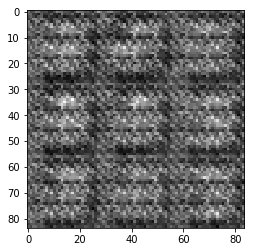

Epoch 1/2... Discriminator Loss: 0.7542... Generator Loss: 2.7964
Epoch 1/2... Discriminator Loss: 0.7821... Generator Loss: 3.6793
Epoch 1/2... Discriminator Loss: 0.7607... Generator Loss: 3.2619
Epoch 1/2... Discriminator Loss: 0.7522... Generator Loss: 2.8619
Epoch 1/2... Discriminator Loss: 0.8594... Generator Loss: 1.8805
Epoch 1/2... Discriminator Loss: 0.7443... Generator Loss: 3.2175
Epoch 1/2... Discriminator Loss: 0.7413... Generator Loss: 4.0495
Epoch 1/2... Discriminator Loss: 0.7618... Generator Loss: 2.8145
Epoch 1/2... Discriminator Loss: 0.7407... Generator Loss: 2.9313
Epoch 1/2... Discriminator Loss: 0.7446... Generator Loss: 3.3580


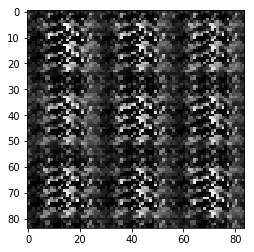

Epoch 1/2... Discriminator Loss: 0.7447... Generator Loss: 2.9507
Epoch 1/2... Discriminator Loss: 0.7443... Generator Loss: 3.3351
Epoch 1/2... Discriminator Loss: 0.7438... Generator Loss: 2.9572
Epoch 1/2... Discriminator Loss: 0.7409... Generator Loss: 3.5446
Epoch 1/2... Discriminator Loss: 0.7810... Generator Loss: 3.1029
Epoch 1/2... Discriminator Loss: 0.7512... Generator Loss: 3.3268
Epoch 1/2... Discriminator Loss: 0.7511... Generator Loss: 3.1365
Epoch 1/2... Discriminator Loss: 0.7594... Generator Loss: 2.9058
Epoch 1/2... Discriminator Loss: 0.7761... Generator Loss: 2.2854
Epoch 1/2... Discriminator Loss: 1.7434... Generator Loss: 6.6030


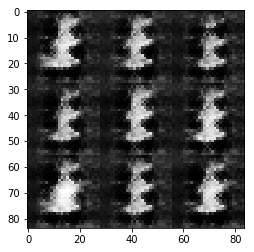

Epoch 1/2... Discriminator Loss: 0.7892... Generator Loss: 2.9242
Epoch 1/2... Discriminator Loss: 0.7575... Generator Loss: 3.1314
Epoch 1/2... Discriminator Loss: 0.7764... Generator Loss: 2.9737
Epoch 1/2... Discriminator Loss: 0.7624... Generator Loss: 2.9785
Epoch 1/2... Discriminator Loss: 0.7560... Generator Loss: 2.8623
Epoch 1/2... Discriminator Loss: 0.7786... Generator Loss: 2.1867
Epoch 1/2... Discriminator Loss: 0.7617... Generator Loss: 2.9927
Epoch 1/2... Discriminator Loss: 0.7667... Generator Loss: 2.7547
Epoch 1/2... Discriminator Loss: 0.7683... Generator Loss: 2.7190
Epoch 1/2... Discriminator Loss: 0.7990... Generator Loss: 1.7543


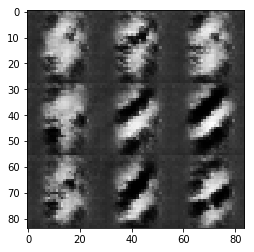

Epoch 1/2... Discriminator Loss: 0.8748... Generator Loss: 1.3276
Epoch 1/2... Discriminator Loss: 0.7798... Generator Loss: 3.2610
Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 2.6602
Epoch 1/2... Discriminator Loss: 0.7513... Generator Loss: 2.7972
Epoch 1/2... Discriminator Loss: 0.7694... Generator Loss: 2.7075
Epoch 1/2... Discriminator Loss: 0.7975... Generator Loss: 2.1722
Epoch 1/2... Discriminator Loss: 0.7586... Generator Loss: 3.0729
Epoch 1/2... Discriminator Loss: 0.7682... Generator Loss: 2.2586
Epoch 1/2... Discriminator Loss: 0.7905... Generator Loss: 3.2916
Epoch 1/2... Discriminator Loss: 0.7630... Generator Loss: 3.2290


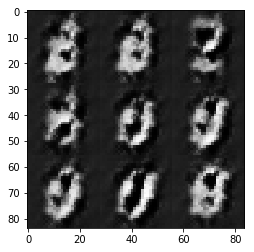

Epoch 1/2... Discriminator Loss: 0.7668... Generator Loss: 2.7063
Epoch 1/2... Discriminator Loss: 0.7889... Generator Loss: 1.8807
Epoch 1/2... Discriminator Loss: 0.8436... Generator Loss: 1.7983
Epoch 1/2... Discriminator Loss: 0.8176... Generator Loss: 2.1512
Epoch 1/2... Discriminator Loss: 1.0626... Generator Loss: 1.5385
Epoch 1/2... Discriminator Loss: 0.7667... Generator Loss: 3.3377
Epoch 1/2... Discriminator Loss: 0.7632... Generator Loss: 2.2940
Epoch 1/2... Discriminator Loss: 0.7577... Generator Loss: 2.8466
Epoch 1/2... Discriminator Loss: 0.7607... Generator Loss: 2.9602
Epoch 1/2... Discriminator Loss: 0.7524... Generator Loss: 3.0151


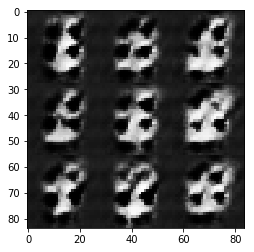

Epoch 1/2... Discriminator Loss: 0.7606... Generator Loss: 3.1000
Epoch 1/2... Discriminator Loss: 0.7613... Generator Loss: 2.8799
Epoch 1/2... Discriminator Loss: 0.7686... Generator Loss: 2.7117
Epoch 1/2... Discriminator Loss: 0.7742... Generator Loss: 3.2224
Epoch 1/2... Discriminator Loss: 0.7660... Generator Loss: 2.5809
Epoch 1/2... Discriminator Loss: 0.7837... Generator Loss: 1.9457
Epoch 1/2... Discriminator Loss: 0.7572... Generator Loss: 3.0647
Epoch 1/2... Discriminator Loss: 0.7848... Generator Loss: 2.1798
Epoch 1/2... Discriminator Loss: 0.8106... Generator Loss: 2.2961
Epoch 1/2... Discriminator Loss: 0.7962... Generator Loss: 2.4432


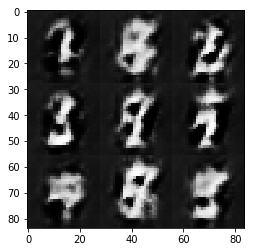

Epoch 1/2... Discriminator Loss: 0.7589... Generator Loss: 2.8082
Epoch 1/2... Discriminator Loss: 0.7822... Generator Loss: 2.9379
Epoch 1/2... Discriminator Loss: 0.7601... Generator Loss: 2.5484
Epoch 1/2... Discriminator Loss: 0.7537... Generator Loss: 2.8582
Epoch 1/2... Discriminator Loss: 0.7701... Generator Loss: 3.1588
Epoch 1/2... Discriminator Loss: 0.8301... Generator Loss: 2.8399
Epoch 1/2... Discriminator Loss: 0.7806... Generator Loss: 2.2446
Epoch 1/2... Discriminator Loss: 0.7535... Generator Loss: 2.6772
Epoch 1/2... Discriminator Loss: 0.9499... Generator Loss: 1.3774
Epoch 1/2... Discriminator Loss: 0.7648... Generator Loss: 2.4789


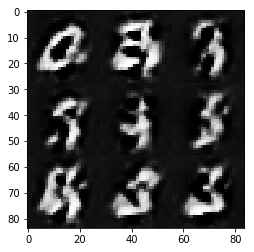

Epoch 1/2... Discriminator Loss: 0.8501... Generator Loss: 3.0315
Epoch 1/2... Discriminator Loss: 0.7638... Generator Loss: 2.1973
Epoch 1/2... Discriminator Loss: 0.8415... Generator Loss: 1.5239
Epoch 1/2... Discriminator Loss: 0.7692... Generator Loss: 2.5452
Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 4.0577
Epoch 1/2... Discriminator Loss: 0.7840... Generator Loss: 2.4415
Epoch 1/2... Discriminator Loss: 0.8307... Generator Loss: 3.0982
Epoch 1/2... Discriminator Loss: 0.7842... Generator Loss: 2.4641
Epoch 1/2... Discriminator Loss: 0.7601... Generator Loss: 2.8838
Epoch 1/2... Discriminator Loss: 0.7792... Generator Loss: 2.5217


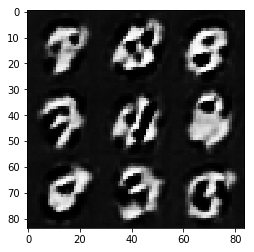

Epoch 1/2... Discriminator Loss: 0.8697... Generator Loss: 2.9574
Epoch 1/2... Discriminator Loss: 0.7665... Generator Loss: 2.6082
Epoch 1/2... Discriminator Loss: 0.8060... Generator Loss: 1.6715
Epoch 1/2... Discriminator Loss: 0.8033... Generator Loss: 2.0642
Epoch 1/2... Discriminator Loss: 0.8634... Generator Loss: 3.1479
Epoch 1/2... Discriminator Loss: 0.7640... Generator Loss: 2.4639
Epoch 1/2... Discriminator Loss: 0.8032... Generator Loss: 2.0288
Epoch 1/2... Discriminator Loss: 0.8380... Generator Loss: 1.7517
Epoch 1/2... Discriminator Loss: 0.7590... Generator Loss: 2.7881
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 1.7069


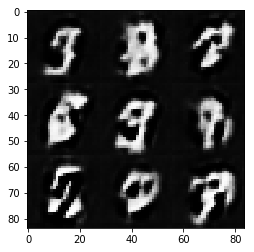

Epoch 1/2... Discriminator Loss: 0.7700... Generator Loss: 2.5028
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 0.9703
Epoch 1/2... Discriminator Loss: 0.7880... Generator Loss: 2.3757
Epoch 1/2... Discriminator Loss: 0.9076... Generator Loss: 1.3586
Epoch 1/2... Discriminator Loss: 1.0160... Generator Loss: 3.1651
Epoch 1/2... Discriminator Loss: 0.7696... Generator Loss: 2.4339
Epoch 1/2... Discriminator Loss: 0.7861... Generator Loss: 1.9774
Epoch 1/2... Discriminator Loss: 0.7606... Generator Loss: 2.3101
Epoch 1/2... Discriminator Loss: 0.7898... Generator Loss: 1.9404
Epoch 1/2... Discriminator Loss: 0.7890... Generator Loss: 2.0306


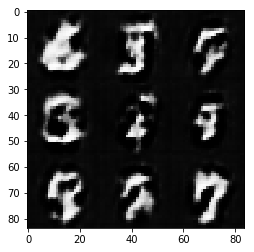

Epoch 1/2... Discriminator Loss: 0.8303... Generator Loss: 2.1356
Epoch 1/2... Discriminator Loss: 0.8322... Generator Loss: 2.3954
Epoch 1/2... Discriminator Loss: 0.8345... Generator Loss: 1.5658
Epoch 1/2... Discriminator Loss: 0.8424... Generator Loss: 1.5969
Epoch 1/2... Discriminator Loss: 0.9008... Generator Loss: 1.3487
Epoch 1/2... Discriminator Loss: 0.7629... Generator Loss: 2.3964
Epoch 1/2... Discriminator Loss: 1.3193... Generator Loss: 3.8391
Epoch 1/2... Discriminator Loss: 0.8251... Generator Loss: 1.7048
Epoch 1/2... Discriminator Loss: 0.7881... Generator Loss: 2.0405
Epoch 1/2... Discriminator Loss: 0.7601... Generator Loss: 2.0157


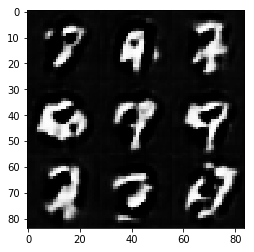

Epoch 1/2... Discriminator Loss: 0.7780... Generator Loss: 2.3735
Epoch 1/2... Discriminator Loss: 0.7781... Generator Loss: 2.2577
Epoch 1/2... Discriminator Loss: 0.7761... Generator Loss: 2.4650
Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 2.2608
Epoch 1/2... Discriminator Loss: 0.9337... Generator Loss: 1.2864
Epoch 1/2... Discriminator Loss: 0.7812... Generator Loss: 2.6398
Epoch 1/2... Discriminator Loss: 0.9584... Generator Loss: 1.0959
Epoch 1/2... Discriminator Loss: 1.0657... Generator Loss: 2.9740
Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 1.3728
Epoch 1/2... Discriminator Loss: 0.7956... Generator Loss: 1.9835


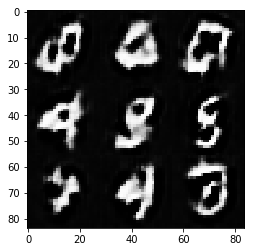

Epoch 1/2... Discriminator Loss: 1.0893... Generator Loss: 2.8151
Epoch 1/2... Discriminator Loss: 0.9032... Generator Loss: 2.9229
Epoch 1/2... Discriminator Loss: 0.9191... Generator Loss: 2.6799
Epoch 1/2... Discriminator Loss: 0.9535... Generator Loss: 1.0420
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 1.1152
Epoch 1/2... Discriminator Loss: 0.8194... Generator Loss: 1.9508
Epoch 1/2... Discriminator Loss: 0.9485... Generator Loss: 2.3742
Epoch 1/2... Discriminator Loss: 0.9139... Generator Loss: 1.6365
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 2.6471
Epoch 1/2... Discriminator Loss: 0.8825... Generator Loss: 1.6035


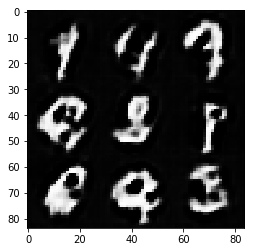

Epoch 1/2... Discriminator Loss: 0.8990... Generator Loss: 2.5724
Epoch 1/2... Discriminator Loss: 0.8156... Generator Loss: 1.6524
Epoch 1/2... Discriminator Loss: 0.9009... Generator Loss: 2.6301
Epoch 1/2... Discriminator Loss: 0.9143... Generator Loss: 1.4860
Epoch 1/2... Discriminator Loss: 0.8241... Generator Loss: 1.7831
Epoch 1/2... Discriminator Loss: 1.1428... Generator Loss: 0.9576
Epoch 1/2... Discriminator Loss: 0.9082... Generator Loss: 1.1702
Epoch 1/2... Discriminator Loss: 0.8528... Generator Loss: 1.5459
Epoch 1/2... Discriminator Loss: 0.9927... Generator Loss: 2.6237
Epoch 1/2... Discriminator Loss: 0.8335... Generator Loss: 2.2822


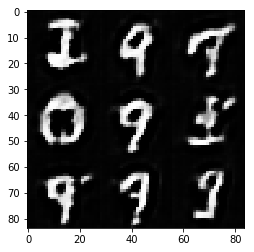

Epoch 1/2... Discriminator Loss: 0.9589... Generator Loss: 2.7340
Epoch 1/2... Discriminator Loss: 0.9648... Generator Loss: 1.1221
Epoch 1/2... Discriminator Loss: 0.8365... Generator Loss: 1.5558
Epoch 1/2... Discriminator Loss: 0.9203... Generator Loss: 1.7117
Epoch 1/2... Discriminator Loss: 0.8602... Generator Loss: 1.6465
Epoch 1/2... Discriminator Loss: 0.8694... Generator Loss: 2.2109
Epoch 1/2... Discriminator Loss: 0.7956... Generator Loss: 1.9091
Epoch 1/2... Discriminator Loss: 0.8374... Generator Loss: 1.6666
Epoch 1/2... Discriminator Loss: 0.8331... Generator Loss: 1.6064
Epoch 1/2... Discriminator Loss: 0.8697... Generator Loss: 1.8565


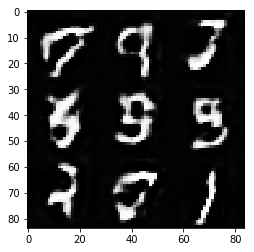

Epoch 1/2... Discriminator Loss: 0.9652... Generator Loss: 2.6036
Epoch 1/2... Discriminator Loss: 0.8456... Generator Loss: 1.9807
Epoch 1/2... Discriminator Loss: 0.9104... Generator Loss: 1.7543
Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 1.0511
Epoch 1/2... Discriminator Loss: 0.9342... Generator Loss: 1.4483
Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 2.9474
Epoch 1/2... Discriminator Loss: 0.9585... Generator Loss: 2.0270
Epoch 1/2... Discriminator Loss: 0.8860... Generator Loss: 1.7216
Epoch 1/2... Discriminator Loss: 0.8651... Generator Loss: 1.5546
Epoch 1/2... Discriminator Loss: 0.9777... Generator Loss: 1.1504


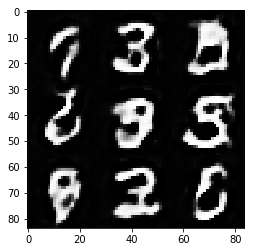

Epoch 1/2... Discriminator Loss: 0.8828... Generator Loss: 2.0246
Epoch 1/2... Discriminator Loss: 0.9802... Generator Loss: 1.1576
Epoch 1/2... Discriminator Loss: 0.8864... Generator Loss: 1.5698
Epoch 1/2... Discriminator Loss: 0.8616... Generator Loss: 2.0697
Epoch 1/2... Discriminator Loss: 0.9229... Generator Loss: 1.1988
Epoch 1/2... Discriminator Loss: 0.9148... Generator Loss: 1.4586
Epoch 1/2... Discriminator Loss: 0.9708... Generator Loss: 2.0436
Epoch 1/2... Discriminator Loss: 0.9031... Generator Loss: 1.7016
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 1.1935
Epoch 1/2... Discriminator Loss: 0.9094... Generator Loss: 1.7799


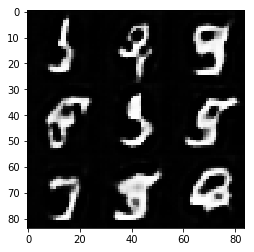

Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 1.7756
Epoch 1/2... Discriminator Loss: 0.9923... Generator Loss: 2.0835
Epoch 1/2... Discriminator Loss: 0.9946... Generator Loss: 2.3808
Epoch 1/2... Discriminator Loss: 0.9396... Generator Loss: 1.2396
Epoch 1/2... Discriminator Loss: 0.8801... Generator Loss: 1.8671
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 1.3146
Epoch 1/2... Discriminator Loss: 0.9205... Generator Loss: 1.6022
Epoch 2/2... Discriminator Loss: 0.8938... Generator Loss: 1.3087
Epoch 2/2... Discriminator Loss: 1.0656... Generator Loss: 2.3351
Epoch 2/2... Discriminator Loss: 0.9061... Generator Loss: 1.9690


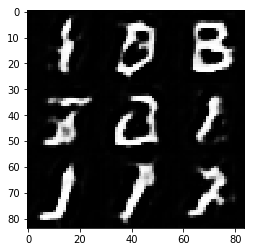

Epoch 2/2... Discriminator Loss: 0.9659... Generator Loss: 1.2164
Epoch 2/2... Discriminator Loss: 0.9600... Generator Loss: 1.1900
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 1.9478
Epoch 2/2... Discriminator Loss: 1.1028... Generator Loss: 1.0808
Epoch 2/2... Discriminator Loss: 1.0571... Generator Loss: 1.8323
Epoch 2/2... Discriminator Loss: 0.9979... Generator Loss: 2.1755
Epoch 2/2... Discriminator Loss: 0.9432... Generator Loss: 1.1248
Epoch 2/2... Discriminator Loss: 0.9963... Generator Loss: 1.3008
Epoch 2/2... Discriminator Loss: 0.9193... Generator Loss: 1.3171
Epoch 2/2... Discriminator Loss: 0.9574... Generator Loss: 1.2940


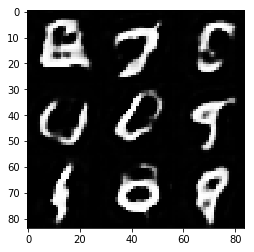

Epoch 2/2... Discriminator Loss: 0.9726... Generator Loss: 1.8738
Epoch 2/2... Discriminator Loss: 1.0016... Generator Loss: 1.9847
Epoch 2/2... Discriminator Loss: 1.0804... Generator Loss: 2.3692
Epoch 2/2... Discriminator Loss: 0.8719... Generator Loss: 1.4012
Epoch 2/2... Discriminator Loss: 1.1999... Generator Loss: 0.7780
Epoch 2/2... Discriminator Loss: 1.0999... Generator Loss: 0.8963
Epoch 2/2... Discriminator Loss: 1.2373... Generator Loss: 0.8179
Epoch 2/2... Discriminator Loss: 0.9694... Generator Loss: 1.4707
Epoch 2/2... Discriminator Loss: 0.9481... Generator Loss: 1.0798
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 1.3922


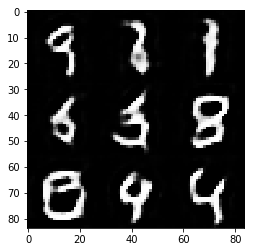

Epoch 2/2... Discriminator Loss: 0.9380... Generator Loss: 1.3643
Epoch 2/2... Discriminator Loss: 0.8790... Generator Loss: 1.6204
Epoch 2/2... Discriminator Loss: 1.0736... Generator Loss: 1.4889
Epoch 2/2... Discriminator Loss: 1.1132... Generator Loss: 1.0946
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 1.0649
Epoch 2/2... Discriminator Loss: 0.9625... Generator Loss: 1.4128
Epoch 2/2... Discriminator Loss: 1.0139... Generator Loss: 1.3964
Epoch 2/2... Discriminator Loss: 0.8911... Generator Loss: 1.6066
Epoch 2/2... Discriminator Loss: 1.0474... Generator Loss: 1.1836
Epoch 2/2... Discriminator Loss: 0.9904... Generator Loss: 1.1543


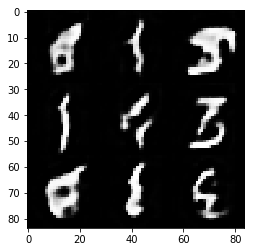

Epoch 2/2... Discriminator Loss: 1.0731... Generator Loss: 2.2136
Epoch 2/2... Discriminator Loss: 1.0535... Generator Loss: 1.0756
Epoch 2/2... Discriminator Loss: 1.0736... Generator Loss: 1.0798
Epoch 2/2... Discriminator Loss: 0.9257... Generator Loss: 1.9967
Epoch 2/2... Discriminator Loss: 1.0888... Generator Loss: 1.3556
Epoch 2/2... Discriminator Loss: 0.9475... Generator Loss: 1.6711
Epoch 2/2... Discriminator Loss: 0.9230... Generator Loss: 1.2690
Epoch 2/2... Discriminator Loss: 1.0323... Generator Loss: 1.7972
Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 2.1499
Epoch 2/2... Discriminator Loss: 1.0257... Generator Loss: 1.1005


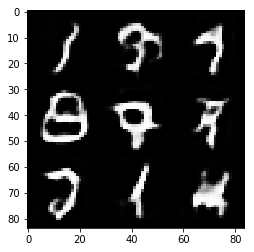

Epoch 2/2... Discriminator Loss: 1.0014... Generator Loss: 1.0121
Epoch 2/2... Discriminator Loss: 0.9348... Generator Loss: 1.6516
Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 1.1297
Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 1.6491
Epoch 2/2... Discriminator Loss: 0.9559... Generator Loss: 1.4352
Epoch 2/2... Discriminator Loss: 1.0168... Generator Loss: 1.3121
Epoch 2/2... Discriminator Loss: 0.9282... Generator Loss: 1.6789
Epoch 2/2... Discriminator Loss: 1.2011... Generator Loss: 0.9844
Epoch 2/2... Discriminator Loss: 0.9579... Generator Loss: 1.1674
Epoch 2/2... Discriminator Loss: 0.8849... Generator Loss: 2.0006


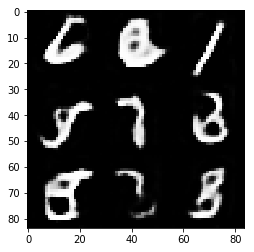

Epoch 2/2... Discriminator Loss: 0.9747... Generator Loss: 1.7609
Epoch 2/2... Discriminator Loss: 0.9539... Generator Loss: 1.3248
Epoch 2/2... Discriminator Loss: 1.0515... Generator Loss: 1.3812
Epoch 2/2... Discriminator Loss: 1.0940... Generator Loss: 0.9530
Epoch 2/2... Discriminator Loss: 0.9105... Generator Loss: 1.3206
Epoch 2/2... Discriminator Loss: 0.9685... Generator Loss: 1.2023
Epoch 2/2... Discriminator Loss: 0.8982... Generator Loss: 1.7615
Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 2.1117
Epoch 2/2... Discriminator Loss: 0.9269... Generator Loss: 1.1400
Epoch 2/2... Discriminator Loss: 0.9925... Generator Loss: 1.2518


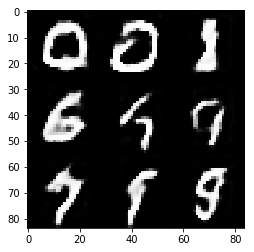

Epoch 2/2... Discriminator Loss: 1.0229... Generator Loss: 1.6255
Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 1.4542
Epoch 2/2... Discriminator Loss: 1.0505... Generator Loss: 1.8818
Epoch 2/2... Discriminator Loss: 0.9194... Generator Loss: 1.5764
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 1.6409
Epoch 2/2... Discriminator Loss: 1.0231... Generator Loss: 0.9992
Epoch 2/2... Discriminator Loss: 0.9432... Generator Loss: 1.1320
Epoch 2/2... Discriminator Loss: 0.9398... Generator Loss: 1.4047
Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 1.6323
Epoch 2/2... Discriminator Loss: 0.9658... Generator Loss: 1.5407


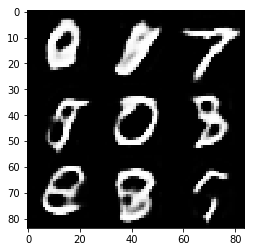

Epoch 2/2... Discriminator Loss: 0.9811... Generator Loss: 1.4311
Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 1.8673
Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 1.9472
Epoch 2/2... Discriminator Loss: 0.8855... Generator Loss: 1.5513
Epoch 2/2... Discriminator Loss: 0.9938... Generator Loss: 1.0209
Epoch 2/2... Discriminator Loss: 0.9889... Generator Loss: 1.4656
Epoch 2/2... Discriminator Loss: 0.9167... Generator Loss: 1.5538
Epoch 2/2... Discriminator Loss: 0.9251... Generator Loss: 1.5895
Epoch 2/2... Discriminator Loss: 1.0060... Generator Loss: 1.3237
Epoch 2/2... Discriminator Loss: 0.9005... Generator Loss: 1.6242


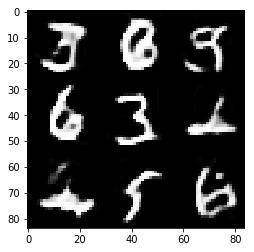

Epoch 2/2... Discriminator Loss: 0.9190... Generator Loss: 1.8324
Epoch 2/2... Discriminator Loss: 0.9964... Generator Loss: 1.3256
Epoch 2/2... Discriminator Loss: 1.0164... Generator Loss: 1.1315
Epoch 2/2... Discriminator Loss: 1.0110... Generator Loss: 1.6184
Epoch 2/2... Discriminator Loss: 0.9876... Generator Loss: 1.1337
Epoch 2/2... Discriminator Loss: 1.0338... Generator Loss: 2.1332
Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 0.9879
Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 1.7278
Epoch 2/2... Discriminator Loss: 0.9403... Generator Loss: 1.2088
Epoch 2/2... Discriminator Loss: 1.0535... Generator Loss: 1.2027


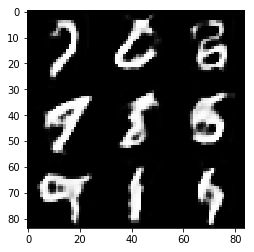

Epoch 2/2... Discriminator Loss: 1.0022... Generator Loss: 1.2565
Epoch 2/2... Discriminator Loss: 0.9158... Generator Loss: 2.3530
Epoch 2/2... Discriminator Loss: 1.0239... Generator Loss: 1.9903
Epoch 2/2... Discriminator Loss: 0.9958... Generator Loss: 1.1427
Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 2.0104
Epoch 2/2... Discriminator Loss: 0.9983... Generator Loss: 1.1048
Epoch 2/2... Discriminator Loss: 1.1134... Generator Loss: 1.1534
Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 1.0815
Epoch 2/2... Discriminator Loss: 1.0296... Generator Loss: 1.1850
Epoch 2/2... Discriminator Loss: 0.9936... Generator Loss: 1.3300


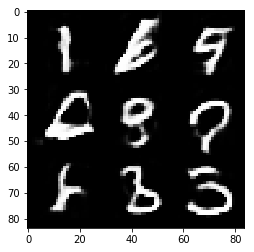

Epoch 2/2... Discriminator Loss: 0.9808... Generator Loss: 1.7812
Epoch 2/2... Discriminator Loss: 1.1264... Generator Loss: 2.1859
Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 1.1819
Epoch 2/2... Discriminator Loss: 0.9970... Generator Loss: 1.1708
Epoch 2/2... Discriminator Loss: 0.9813... Generator Loss: 1.1783
Epoch 2/2... Discriminator Loss: 0.9675... Generator Loss: 1.5734
Epoch 2/2... Discriminator Loss: 0.9829... Generator Loss: 1.2893
Epoch 2/2... Discriminator Loss: 1.0164... Generator Loss: 1.8480
Epoch 2/2... Discriminator Loss: 0.9365... Generator Loss: 1.1512
Epoch 2/2... Discriminator Loss: 0.9112... Generator Loss: 1.7565


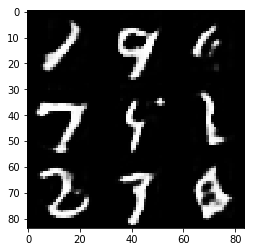

Epoch 2/2... Discriminator Loss: 0.9381... Generator Loss: 1.5639
Epoch 2/2... Discriminator Loss: 0.9912... Generator Loss: 1.9193
Epoch 2/2... Discriminator Loss: 0.9754... Generator Loss: 1.0910
Epoch 2/2... Discriminator Loss: 0.9358... Generator Loss: 1.7911
Epoch 2/2... Discriminator Loss: 1.0694... Generator Loss: 1.0890
Epoch 2/2... Discriminator Loss: 0.9607... Generator Loss: 1.2937
Epoch 2/2... Discriminator Loss: 0.8986... Generator Loss: 1.4714
Epoch 2/2... Discriminator Loss: 0.9005... Generator Loss: 1.2812
Epoch 2/2... Discriminator Loss: 1.0352... Generator Loss: 1.9722
Epoch 2/2... Discriminator Loss: 0.9957... Generator Loss: 1.7224


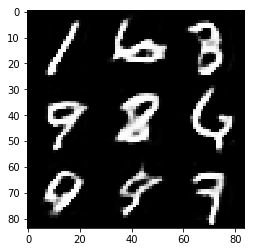

Epoch 2/2... Discriminator Loss: 0.9477... Generator Loss: 1.6271
Epoch 2/2... Discriminator Loss: 0.9301... Generator Loss: 1.3726
Epoch 2/2... Discriminator Loss: 0.9621... Generator Loss: 1.3525
Epoch 2/2... Discriminator Loss: 0.8938... Generator Loss: 1.2656
Epoch 2/2... Discriminator Loss: 0.9107... Generator Loss: 1.4100
Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 1.2685
Epoch 2/2... Discriminator Loss: 1.0448... Generator Loss: 1.1285
Epoch 2/2... Discriminator Loss: 1.0371... Generator Loss: 1.0957
Epoch 2/2... Discriminator Loss: 1.0170... Generator Loss: 1.1831
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.7463


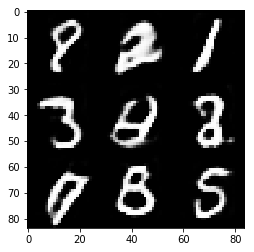

Epoch 2/2... Discriminator Loss: 0.9313... Generator Loss: 1.6193
Epoch 2/2... Discriminator Loss: 0.9731... Generator Loss: 1.0903
Epoch 2/2... Discriminator Loss: 0.9006... Generator Loss: 1.6603
Epoch 2/2... Discriminator Loss: 1.1113... Generator Loss: 1.4407
Epoch 2/2... Discriminator Loss: 1.0494... Generator Loss: 2.1155
Epoch 2/2... Discriminator Loss: 0.9528... Generator Loss: 1.4893
Epoch 2/2... Discriminator Loss: 0.9673... Generator Loss: 1.3693
Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 1.7757
Epoch 2/2... Discriminator Loss: 0.9658... Generator Loss: 1.1344
Epoch 2/2... Discriminator Loss: 0.9087... Generator Loss: 1.8677


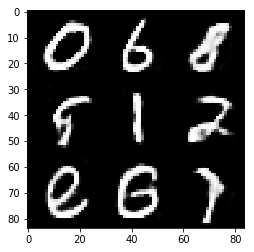

Epoch 2/2... Discriminator Loss: 0.9422... Generator Loss: 1.4721
Epoch 2/2... Discriminator Loss: 0.9292... Generator Loss: 1.6097
Epoch 2/2... Discriminator Loss: 0.8867... Generator Loss: 1.4176
Epoch 2/2... Discriminator Loss: 0.9102... Generator Loss: 1.7433
Epoch 2/2... Discriminator Loss: 0.9210... Generator Loss: 1.6673
Epoch 2/2... Discriminator Loss: 0.9598... Generator Loss: 1.4239
Epoch 2/2... Discriminator Loss: 0.9124... Generator Loss: 1.3538
Epoch 2/2... Discriminator Loss: 1.0945... Generator Loss: 1.7788
Epoch 2/2... Discriminator Loss: 1.0338... Generator Loss: 1.1223
Epoch 2/2... Discriminator Loss: 0.8741... Generator Loss: 1.9396


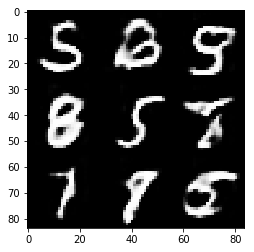

Epoch 2/2... Discriminator Loss: 1.0485... Generator Loss: 1.2388
Epoch 2/2... Discriminator Loss: 1.0033... Generator Loss: 1.8733
Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 1.5672
Epoch 2/2... Discriminator Loss: 0.8938... Generator Loss: 1.5672
Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 1.3843
Epoch 2/2... Discriminator Loss: 1.0567... Generator Loss: 1.7694
Epoch 2/2... Discriminator Loss: 1.0059... Generator Loss: 1.2535
Epoch 2/2... Discriminator Loss: 0.9783... Generator Loss: 1.8947
Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 1.8464
Epoch 2/2... Discriminator Loss: 1.0032... Generator Loss: 1.4647


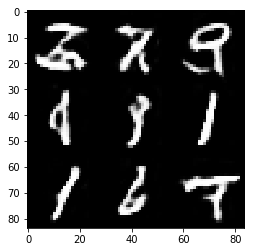

Epoch 2/2... Discriminator Loss: 0.8856... Generator Loss: 1.7515
Epoch 2/2... Discriminator Loss: 0.9868... Generator Loss: 1.7868
Epoch 2/2... Discriminator Loss: 0.9988... Generator Loss: 1.1935
Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 1.2457
Epoch 2/2... Discriminator Loss: 1.0825... Generator Loss: 1.4348
Epoch 2/2... Discriminator Loss: 0.9120... Generator Loss: 1.3197
Epoch 2/2... Discriminator Loss: 0.9654... Generator Loss: 1.7185
Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 1.4708
Epoch 2/2... Discriminator Loss: 1.1337... Generator Loss: 0.9696
Epoch 2/2... Discriminator Loss: 0.9240... Generator Loss: 1.7859


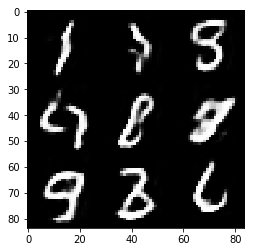

Epoch 2/2... Discriminator Loss: 1.1051... Generator Loss: 0.8404
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 1.7459
Epoch 2/2... Discriminator Loss: 1.1782... Generator Loss: 2.1743
Epoch 2/2... Discriminator Loss: 0.8944... Generator Loss: 1.1862
Epoch 2/2... Discriminator Loss: 0.9249... Generator Loss: 1.3397
Epoch 2/2... Discriminator Loss: 1.0128... Generator Loss: 1.6740
Epoch 2/2... Discriminator Loss: 0.9243... Generator Loss: 1.4141
Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 1.2576
Epoch 2/2... Discriminator Loss: 1.0555... Generator Loss: 2.3562
Epoch 2/2... Discriminator Loss: 0.8909... Generator Loss: 1.5574


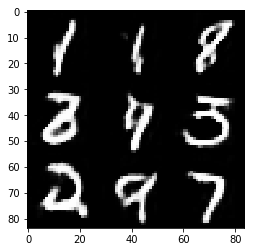

Epoch 2/2... Discriminator Loss: 0.9093... Generator Loss: 1.5188
Epoch 2/2... Discriminator Loss: 0.9553... Generator Loss: 1.4655
Epoch 2/2... Discriminator Loss: 0.9284... Generator Loss: 1.9113
Epoch 2/2... Discriminator Loss: 1.0766... Generator Loss: 1.4744
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 0.9739


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 2.0619
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 2.1465
Epoch 1/1... Discriminator Loss: 0.7590... Generator Loss: 2.4270
Epoch 1/1... Discriminator Loss: 0.7483... Generator Loss: 2.5328
Epoch 1/1... Discriminator Loss: 0.7638... Generator Loss: 2.5511
Epoch 1/1... Discriminator Loss: 0.7480... Generator Loss: 2.6741
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 2.4772
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 2.5567
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 2.3789
Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 2.8603


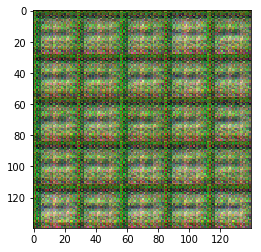

Epoch 1/1... Discriminator Loss: 0.7539... Generator Loss: 2.7073
Epoch 1/1... Discriminator Loss: 0.7449... Generator Loss: 2.6585
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 2.1788
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 2.5685
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 3.1378
Epoch 1/1... Discriminator Loss: 0.7637... Generator Loss: 2.7341
Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 2.7952
Epoch 1/1... Discriminator Loss: 0.8240... Generator Loss: 2.0289
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 2.2235
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.8678


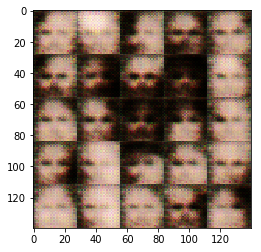

Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 2.6209
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.5724
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.5627
Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 1.6589
Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 2.5532
Epoch 1/1... Discriminator Loss: 0.8328... Generator Loss: 2.1297
Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 2.1224
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 2.2656
Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 2.2236
Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 2.5191


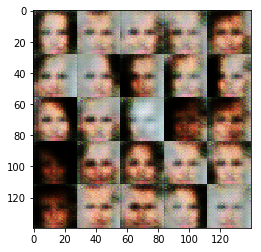

Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 2.4008
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 2.3051
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 1.6169
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 2.9910
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 2.4407
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 1.9984
Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.4427
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 2.4895
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.8612
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 2.3207


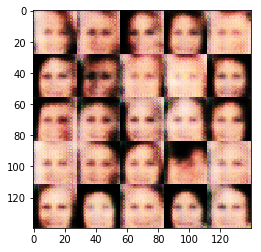

Epoch 1/1... Discriminator Loss: 0.8106... Generator Loss: 2.3277
Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 1.7984
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 1.6382
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 1.5278
Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 1.6575
Epoch 1/1... Discriminator Loss: 0.8285... Generator Loss: 2.0612
Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 2.2873
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 2.1155
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 2.4206
Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 1.8623


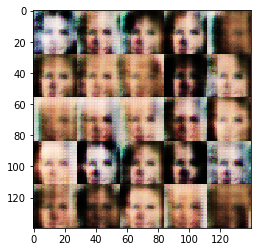

Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 2.0598
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 2.0324
Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 2.1349
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 2.0511
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 1.6235
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 1.6925
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 1.9176
Epoch 1/1... Discriminator Loss: 0.8593... Generator Loss: 1.5358
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 2.4049
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 1.8757


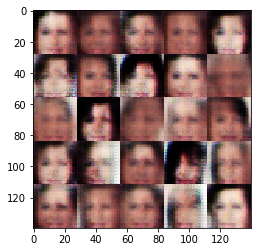

Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 2.6044
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 2.3138
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 2.1081
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 1.9351
Epoch 1/1... Discriminator Loss: 0.7989... Generator Loss: 2.5715
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 2.3341
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.9462
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 2.4842
Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 2.1415
Epoch 1/1... Discriminator Loss: 0.8137... Generator Loss: 2.0814


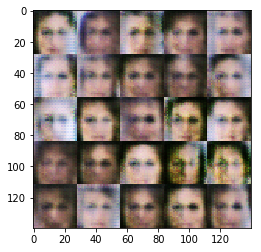

Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 2.9396
Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 2.6583
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 1.6169
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 2.5846
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.8595
Epoch 1/1... Discriminator Loss: 0.8431... Generator Loss: 2.4531
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 2.9443
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 2.3935
Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 1.8606
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 2.3094


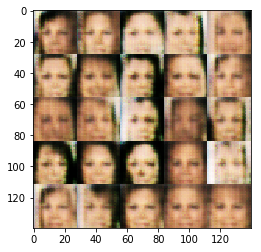

Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.9395
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 1.7099
Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 2.1686
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 1.8419
Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 2.5439
Epoch 1/1... Discriminator Loss: 0.8122... Generator Loss: 2.2470
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.9629
Epoch 1/1... Discriminator Loss: 0.8706... Generator Loss: 1.6987
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 2.1708
Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 2.7111


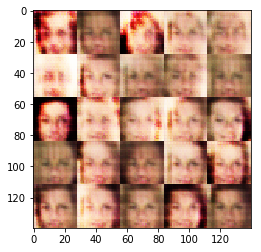

Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 2.0430
Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 1.6163
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.5638
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 2.1010
Epoch 1/1... Discriminator Loss: 0.8722... Generator Loss: 1.6900
Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 1.5142
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 1.9687
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.7785
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.6714
Epoch 1/1... Discriminator Loss: 0.8330... Generator Loss: 1.9474


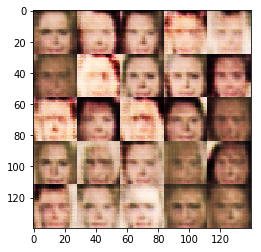

Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 2.4867
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.5697
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.7799
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 1.8781
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 2.1061
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.5237
Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 2.4043
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 2.1110
Epoch 1/1... Discriminator Loss: 0.8625... Generator Loss: 2.1395
Epoch 1/1... Discriminator Loss: 0.8521... Generator Loss: 2.0129


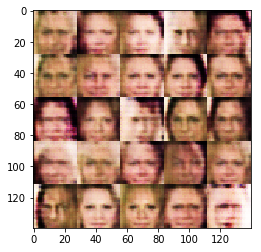

Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 1.7991
Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 2.2437
Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 1.9785
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 2.3665
Epoch 1/1... Discriminator Loss: 0.8169... Generator Loss: 2.4790
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 1.5914
Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 1.7618
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.9957
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 2.0773
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 2.2352


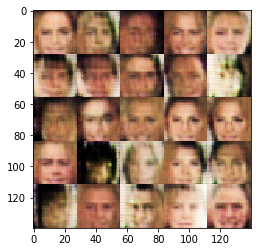

Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 1.6997
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 2.0909
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.7408
Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 2.0299
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.6568
Epoch 1/1... Discriminator Loss: 0.9148... Generator Loss: 1.2784
Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 1.7231
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 1.6202
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 1.8574
Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.6943


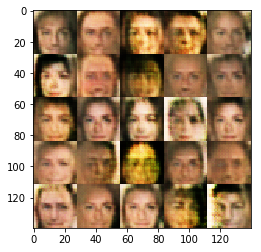

Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 2.1094
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 1.8817
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.8555
Epoch 1/1... Discriminator Loss: 0.8161... Generator Loss: 1.9843
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 1.8787
Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 2.3616
Epoch 1/1... Discriminator Loss: 0.8582... Generator Loss: 2.1642
Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 2.2403
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 2.4123
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.7205


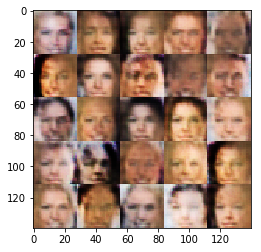

Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 2.3573
Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 2.3014
Epoch 1/1... Discriminator Loss: 0.9019... Generator Loss: 1.8472
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 1.5025
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 1.0805
Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 1.4964
Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 2.0753
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.2515
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 1.1942
Epoch 1/1... Discriminator Loss: 0.8854... Generator Loss: 2.0096


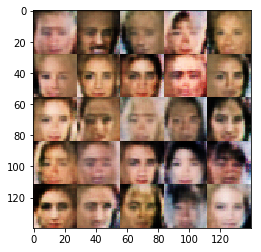

Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.7402
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 1.8303
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 1.6301
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 2.0621
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.5629
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 1.9112
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 2.1646
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 1.3062
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.6899


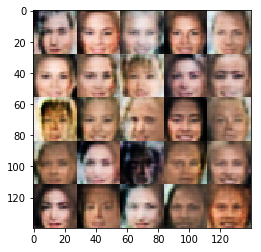

Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 1.7122
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.2144
Epoch 1/1... Discriminator Loss: 0.8294... Generator Loss: 1.8794
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 1.7609
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.3378
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 2.1312
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.9508
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 1.7946
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 1.5658
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.6310


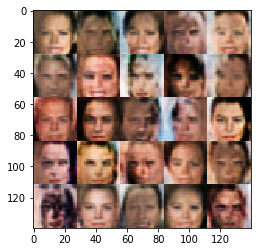

Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 1.6581
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.3358
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.6161
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 1.6376
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.5263
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.7578
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 2.0794
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.5813
Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 1.6318
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 1.2716


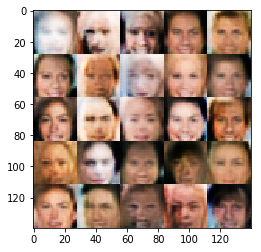

Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.3316
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.8726
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 1.3270
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 1.7461
Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 1.5593
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 1.2396
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.9180
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.2815
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 2.0349
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.5628


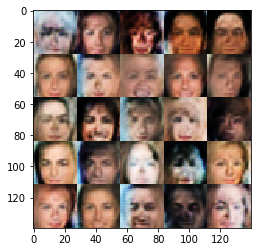

Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 1.6826
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 1.4965
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.6442
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 1.9090
Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 1.4683
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 1.6212
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.6298
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.9372
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 1.3338
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 1.2932


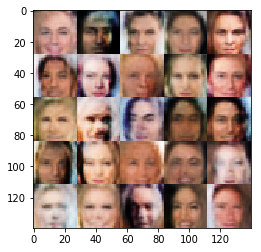

Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 1.4040
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 1.8161
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.4293
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.7770
Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.2490
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 2.0038
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.8991
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.5404
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 1.3919
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 1.4088


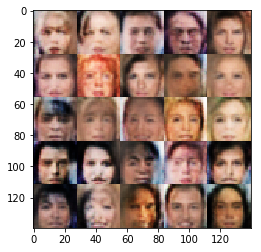

Epoch 1/1... Discriminator Loss: 0.8927... Generator Loss: 1.5322
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.6656
Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.4725
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 1.3559
Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 1.7539
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 1.4812
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 1.0228
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.9381
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.4140


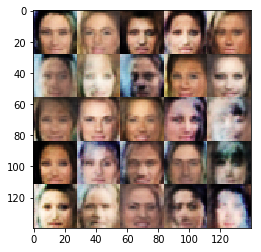

Epoch 1/1... Discriminator Loss: 0.9305... Generator Loss: 1.4440
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 1.5295
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 1.6848
Epoch 1/1... Discriminator Loss: 0.8711... Generator Loss: 2.0173
Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 1.6433
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 1.6239
Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 1.4935
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 1.9475
Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 1.5712
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.7508


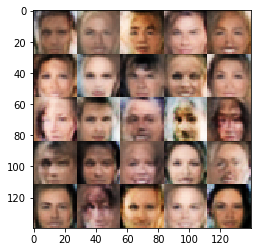

Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 2.0923
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.3837
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 1.4870
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.3526
Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 1.1530
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 2.0217
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.2403
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.6673
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 1.4492
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 1.2462


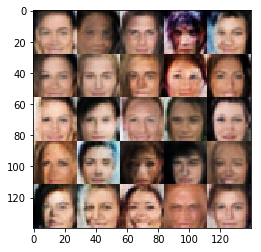

Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 1.6103
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 1.5662
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 1.5715
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.1389
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 1.5708
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 1.5511
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 1.3730
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.5118
Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 1.4549
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.6708


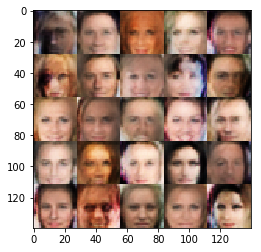

Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 2.0342
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.5861
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.8282
Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 1.5187
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.4802
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 1.3575
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 1.7290
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.3588
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 1.4008


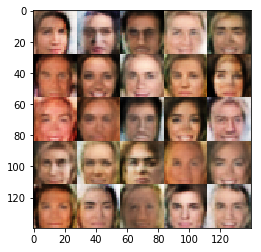

Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.4394
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.5688
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.4707
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 1.1863
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.5910
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 1.4499
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 1.3168
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.8310
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.3261
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 1.6121


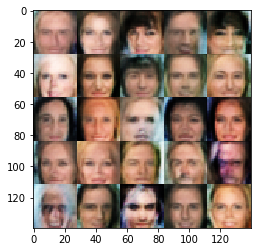

Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 1.5847
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 2.0448
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 1.7167
Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 1.6845
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 1.1734
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 1.6053
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.5387
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 1.4404
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.8145
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 1.5260


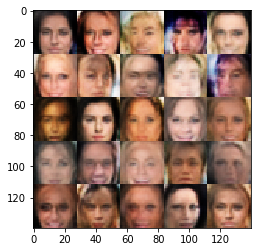

Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.1638
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 1.5833
Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 1.5214
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 1.8217
Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 1.5780
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 1.4025
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.6307
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 1.9296


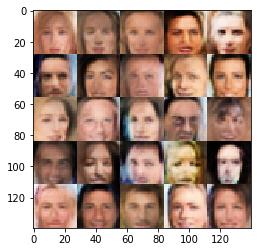

Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 1.6972
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.4718
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.4416
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 1.9974
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.2386
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.3957
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.6431
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 1.4875
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 1.1617


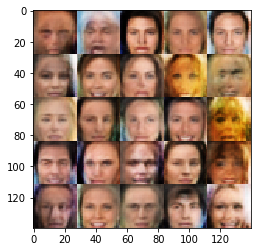

Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.2253
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 1.0687
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 1.5570
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 1.4616
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.7405
Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 1.4988
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.8283
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 1.6901
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 1.1815


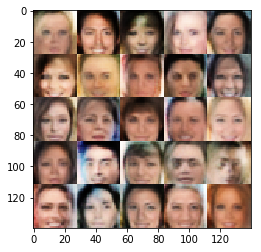

Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 1.6925
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 1.1929
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.4791
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.1501
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.3743
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.6974
Epoch 1/1... Discriminator Loss: 0.9305... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.6288


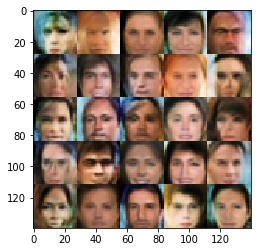

Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 1.1378
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 1.7158
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.4436
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 1.7431
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 1.5925
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.4904
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.7340
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.4861


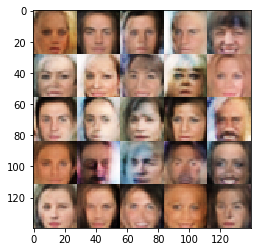

Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 1.4217
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.2073
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 1.8371
Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 1.6310
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.4838
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 1.2935
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 1.3911
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.5277
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 1.2848
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 1.4922


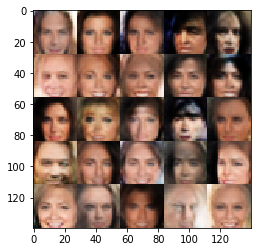

Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 1.6815
Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 1.5695
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.4295
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.4840
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 1.5170
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 1.1753
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.2324
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 1.2829


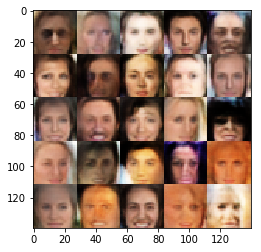

Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 1.5323
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 1.3454
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 1.3037
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 1.0664
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 2.1511
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.5444
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.4030
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.3257


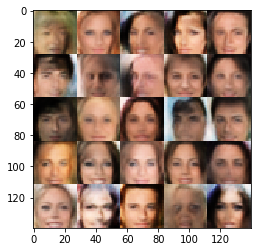

Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.0172
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.5529
Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 1.3596
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 1.4105
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 1.3059
Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 1.9922
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 1.4160
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 1.5530


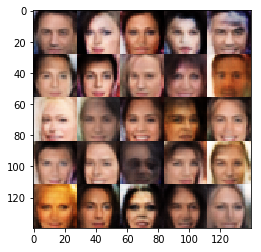

Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.3037
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.1629
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 1.5758
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 1.4839
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.1528
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 1.6050
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 1.6301
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.4500
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.5953


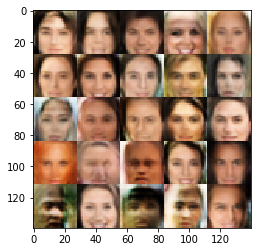

Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 1.4385
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.3195
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 1.4576
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 1.4630
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 2.0214
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.4461
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 1.5775


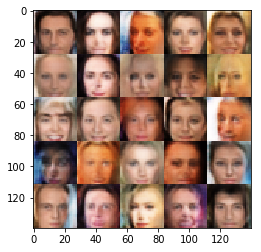

Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 1.4750
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.3007
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.2071
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.4674
Epoch 1/1... Discriminator Loss: 0.9301... Generator Loss: 1.5264
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 1.4276
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.4943
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 1.3687


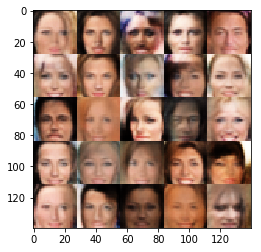

Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 1.7132
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.4063
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.4742
Epoch 1/1... Discriminator Loss: 0.8299... Generator Loss: 1.5362
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 1.2418
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.5381
Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 1.0698
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 1.2824


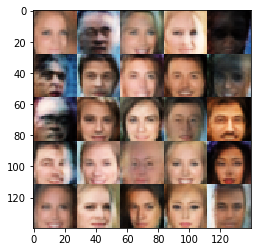

Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.7667
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.2571
Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 1.4912
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 1.7620
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 1.5213
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 1.1224
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 1.3651


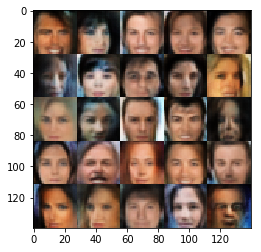

Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 1.3706
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 1.4036
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.5038
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 1.5075
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 1.2594
Epoch 1/1... Discriminator Loss: 0.8904... Generator Loss: 1.4304
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.7443
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 1.1243
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 1.7019
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.4014


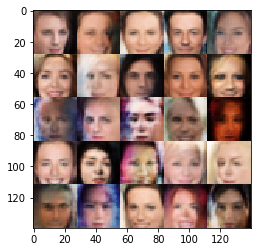

Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 1.2902
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 1.2046
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.2913
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 1.1073
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 1.2825
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.4935
Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.8012
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.4227


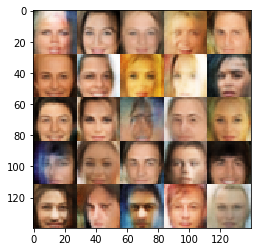

Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 1.5294
Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 1.5396
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 1.2948
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 1.4798
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 1.4108
Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 1.2216
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 1.4658
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 1.7307
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 1.3776


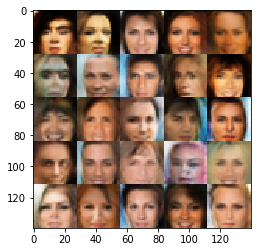

Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 1.4195
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 1.5989
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 1.7843
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.3074
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.2835
Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 1.5886
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 1.5079
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.1279
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 1.1106
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.1909


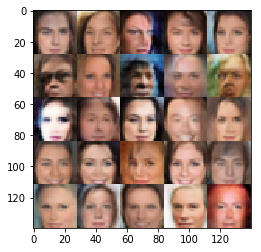

Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.2446
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.4528
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 1.2554
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.2043
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.4423
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 1.5885
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.3012
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 1.0959
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.3276
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 1.5586


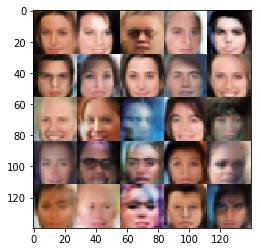

Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 1.2904
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 1.4482
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 1.3003
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.5148
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.3939
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 1.6328
Epoch 1/1... Discriminator Loss: 0.8874... Generator Loss: 1.2905
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 1.3416
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.5014


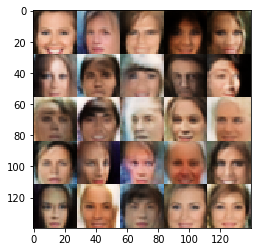

Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.3203
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 1.3707
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 1.6343
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 1.5657
Epoch 1/1... Discriminator Loss: 0.9782... Generator Loss: 1.3413
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.1181
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 1.2901
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.5020
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 1.1208


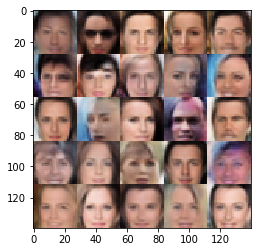

Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.2918
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 0.9335... Generator Loss: 1.7298
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 1.3555
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.4116
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 1.1859
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 1.7119
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 1.5312
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 1.3156
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 1.3150


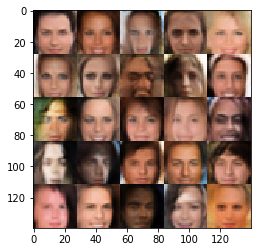

Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 1.1146
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 1.5008
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 1.6364
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 1.2383
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 1.3196
Epoch 1/1... Discriminator Loss: 0.8711... Generator Loss: 1.9627
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 1.4014


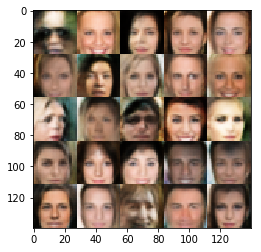

Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.3977
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 1.6416
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.5750
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.1209
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 1.3987
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.4562


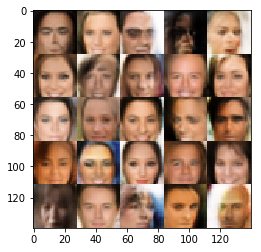

Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.5734
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.2492
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.5930
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 1.2740
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.3727
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 1.2536
Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 1.9790
Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 1.4321
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 1.1106
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 1.4788


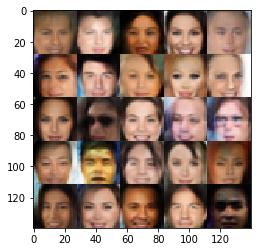

Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 1.3826
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 1.4380
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 1.4738
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 1.4358
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.1957
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 1.3920
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 1.2543
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 1.6526
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 1.6333


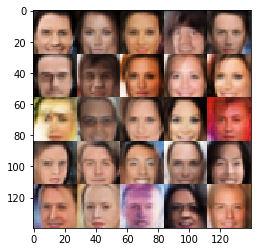

Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 1.2934
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 1.8241
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 1.2534
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 1.6479
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.4880
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 1.4267
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 1.2609
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.1021


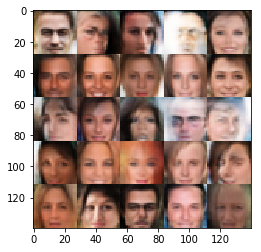

Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 1.1396
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.3970
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 1.0678
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 1.0055
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.8341


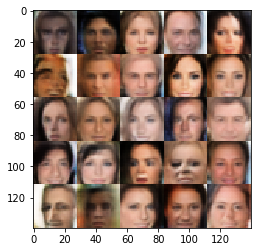

Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.2839
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.5831
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 1.4867
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 1.3004
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.2890
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 1.5354
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.2161
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 1.1727
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.9705
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 1.3782


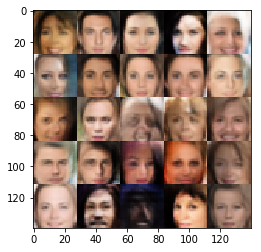

Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 1.4805
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.2210
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 1.1581
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.1506
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 1.1656


KeyboardInterrupt: 

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.